# Riemannian Geodesics

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap, jit, hessian

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import os

from geometry.manifolds.riemannian import RiemannianManifold
from geometry.geodesics.riemannian import JAXOptimization, ScipyOptimization, GEORCE
from geometry.manifolds.riemannian import nEllipsoid, nSphere, nParaboloid, T2, RiemannianManifold, FisherRaoGeometry

In [2]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
figure_path = '../figures/riemannian/geodesics/'

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Hyper-Parameters

In [5]:
T=100
tol = 1e-4
max_iter = 100

jax_lr_rate = 0.01

### Estimation Plot 

In [6]:
def compute_estimates(M, Geodesic, z0, zT, base_curve):
    
    new_method = {}
    zt, grad, idx = Geodesic(z0,zT, "while")
    if M.f is not None:
        xt = vmap(lambda z: M.f(z))(zt)
    else:
        xt = None
    length = M.length(zt)
    
    new_method['zt'] = zt
    new_method['grad'] = grad
    new_method['idx'] = idx
    new_method['xt'] = xt
    new_method['length'] = length
    
    zt, grad, _ = Geodesic(z0,zT, "for")
    error_base_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve))(zt)
    error_iter_curve = vmap(lambda z1,z2: jnp.linalg.norm(z1-z2))(zt[1:], zt[:-1])
    grad_curve = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)
    
    new_method['error_base_curve'] = error_base_curve
    new_method['error_iter_curve'] = error_iter_curve
    new_method['grad_curve'] = grad_curve
    
    return new_method

In [7]:
def compute_methods(M, z0, zT, rho=.9, max_iter=max_iter,
                   tol=tol, T=T):
    
    estimates = {}
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      line_search_method="soft",
                      max_iter=max_iter,
                      line_search_params={'rho': rho}
                     )
    base_curve, *_ = Geodesic(z0,zT, "while")
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      line_search_method="soft",
                      max_iter=max_iter,
                      line_search_params={'rho': rho}
                     )
    estimates['GEORCE'] = compute_estimates(M, Geodesic, z0, zT, base_curve)

    Geodesic = JAXOptimization(M = M,
                              init_fun=None,
                              lr_rate=jax_lr_rate,
                              optimizer=None,
                              T=T,
                              max_iter=max_iter,
                              tol=tol)
    estimates['ADAM'] = compute_estimates(M, Geodesic, z0, zT, base_curve)

    Geodesic = ScipyOptimization(M = M,
                                 T=T,
                                 tol=tol,
                                 max_iter=max_iter,
                                 method="BFGS",
                                )
    estimates['BFGS'] = compute_estimates(M, Geodesic, z0, zT, base_curve)
    
    zt = Geodesic.init_fun(z0,zT, T)
    if M.f is not None:
        xt = vmap(lambda z: M.f(z))(zt)
    else:
        xt = None
    length = M.length(zt)
    
    new_method = {}
    new_method['zt'] = zt
    new_method['grad'] = None
    new_method['idx'] = None
    new_method['xt'] = xt
    new_method['length'] = length
    estimates['Initilization'] = new_method
    
    if hasattr(M, "Geodesic"):
        xt = M.Geodesic(z0,zT)
        zt = vmap(M.invf)(xt)
        length = M.length(zt)
    else:
        xt = None
        zt = None
        length = None
        
    new_method = {}
    new_method['zt'] = zt
    new_method['grad'] = None
    new_method['idx'] = None
    new_method['xt'] = xt
    new_method['length'] = length
    estimates['Ground truth'] = new_method
    
    return estimates

## Estimating Geodesics

### Ellipsoid(2)

In [8]:
params = jnp.linspace(0.5,1.0,3)[::-1]
M = nEllipsoid(dim=2, params=params)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

e2_x0 = M.f(z0)
e2_xT = M.f(zT)

ellipsoid_methods = compute_methods(M, z0, zT, rho=0.5)

/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


### $\mathbb{S}^{2}$

In [49]:
M = nSphere(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = M.f(z0)
s2_xT = M.f(zT)

sphere_methods = compute_methods(M, z0, zT, rho=0.5)

### Paraboloid(2)

In [50]:
M = nParaboloid(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2)

p2_x0 = M.f(z0)
p2_xT = M.f(zT)

paraboloid_methods = compute_methods(M, z0, zT, rho=0.5)

### $\mathbb{T}^{2}$

In [51]:
M = T2(R=3.0, r=1.0)
z0 = jnp.array([0.0, 0.0])
zT = jnp.array([5*jnp.pi/4, 5*jnp.pi/4])

t2_x0 = M.f(z0)
t2_xT = M.f(zT)

torus_methods = compute_methods(M, z0, zT, rho=0.5)

## Plotting Geodesics

In [52]:
class EllipsoidPlot(ABC):
    def __init__(self, params=jnp.linspace(0.5,1.0,3)[::-1]):
        
        self.params = params

    def grid(self, n_points:int=100):
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

In [53]:
class TorusPlot(ABC):
    def __init__(self, R:float=3.0, r:float=1.0):
        
        self.R = R
        self.r = r
        
    def grid(self, n_points:int=100):
        
        U = jnp.linspace(0, 2*jnp.pi, n_points)
        V = jnp.linspace(0, 2*jnp.pi, n_points)
        U, V = jnp.meshgrid(U, V)
        X = (self.R+self.r*jnp.cos(V))*jnp.cos(U)
        Y = (self.R+self.r*jnp.cos(V))*jnp.sin(U)
        Z = self.r*jnp.sin(V)
        
        return X, Y, Z

In [54]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

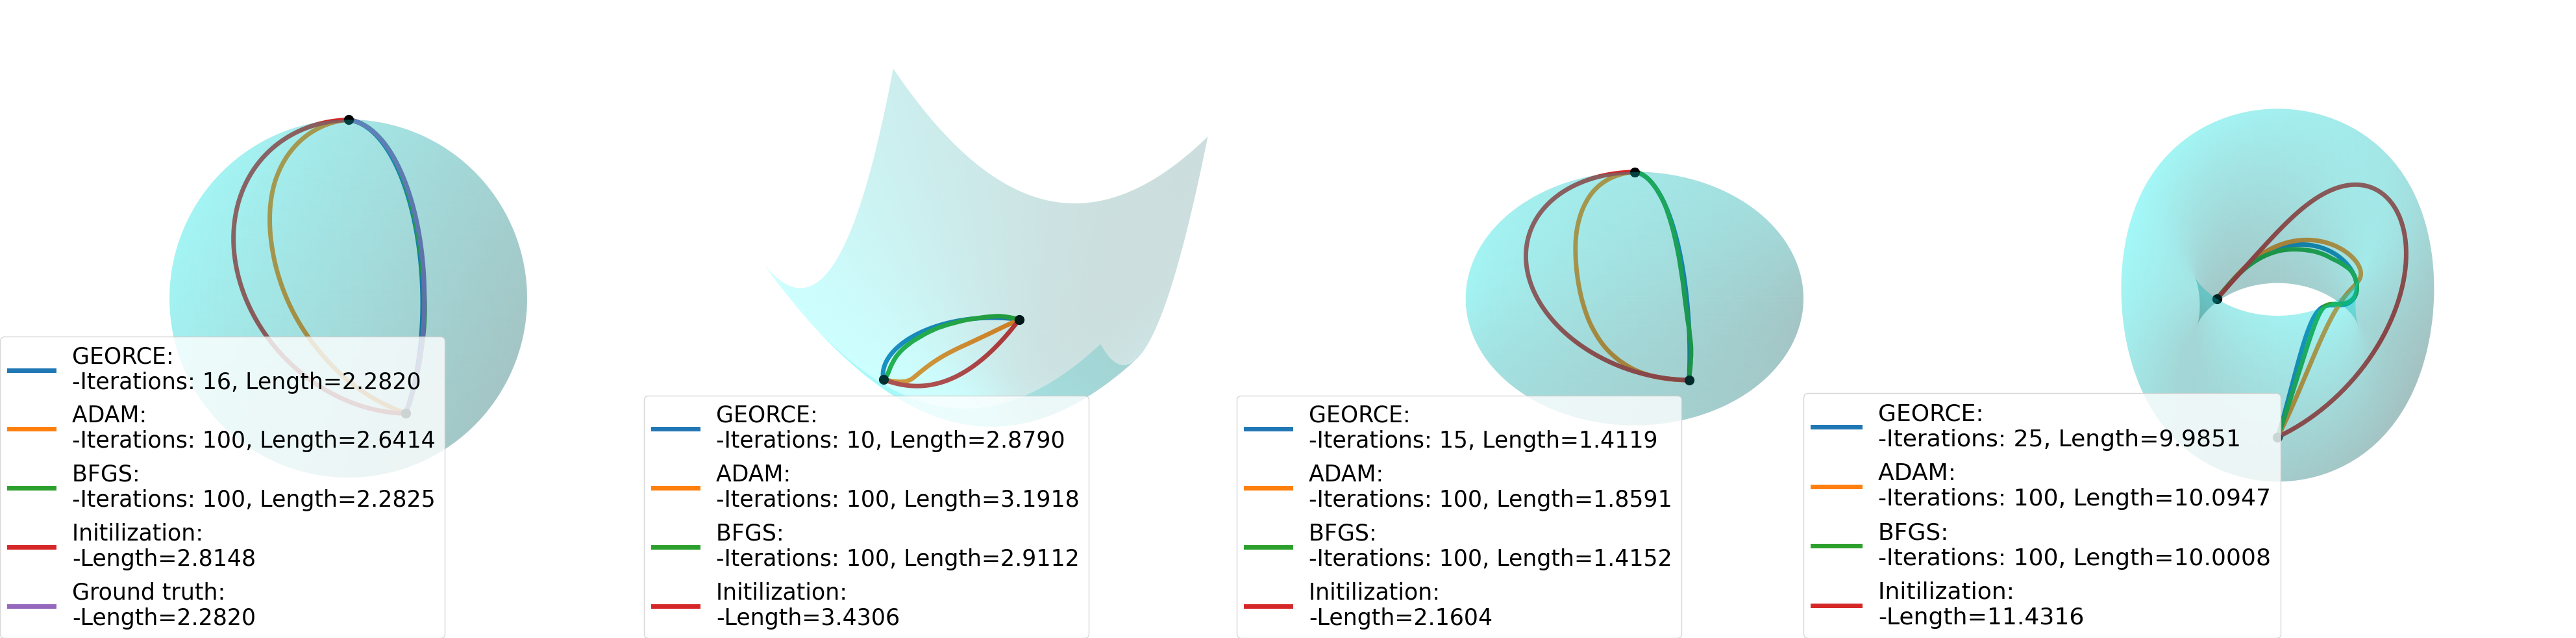

In [62]:
fig = plt.figure(figsize=(40,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in sphere_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)
    
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0,0.0), ncol=1)

#plotting paraboloid
plot_sphere = ParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(142, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in paraboloid_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(p2_x0[0], p2_x0[1], p2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(p2_xT[0], p2_xT[1], p2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.0), ncol=1)

#plotting Ellipsoid
plot_sphere = EllipsoidPlot()
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(143, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in ellipsoid_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)
    
ax.scatter(e2_x0[0], e2_x0[1], e2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(e2_xT[0], e2_xT[1], e2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.48, 0.0), ncol=1)

#plotting Torus
plot_sphere = TorusPlot(R=3.0, r=1.0)
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(144, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in torus_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(t2_x0[0], t2_x0[1], t2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(t2_xT[0], t2_xT[1], t2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=60., azim=0)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.70, 0.0), ncol=1)

fig.tight_layout()

save_path = f'{figure_path}synthetic_riemannian_geodesics.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()




## Plotting Gradients

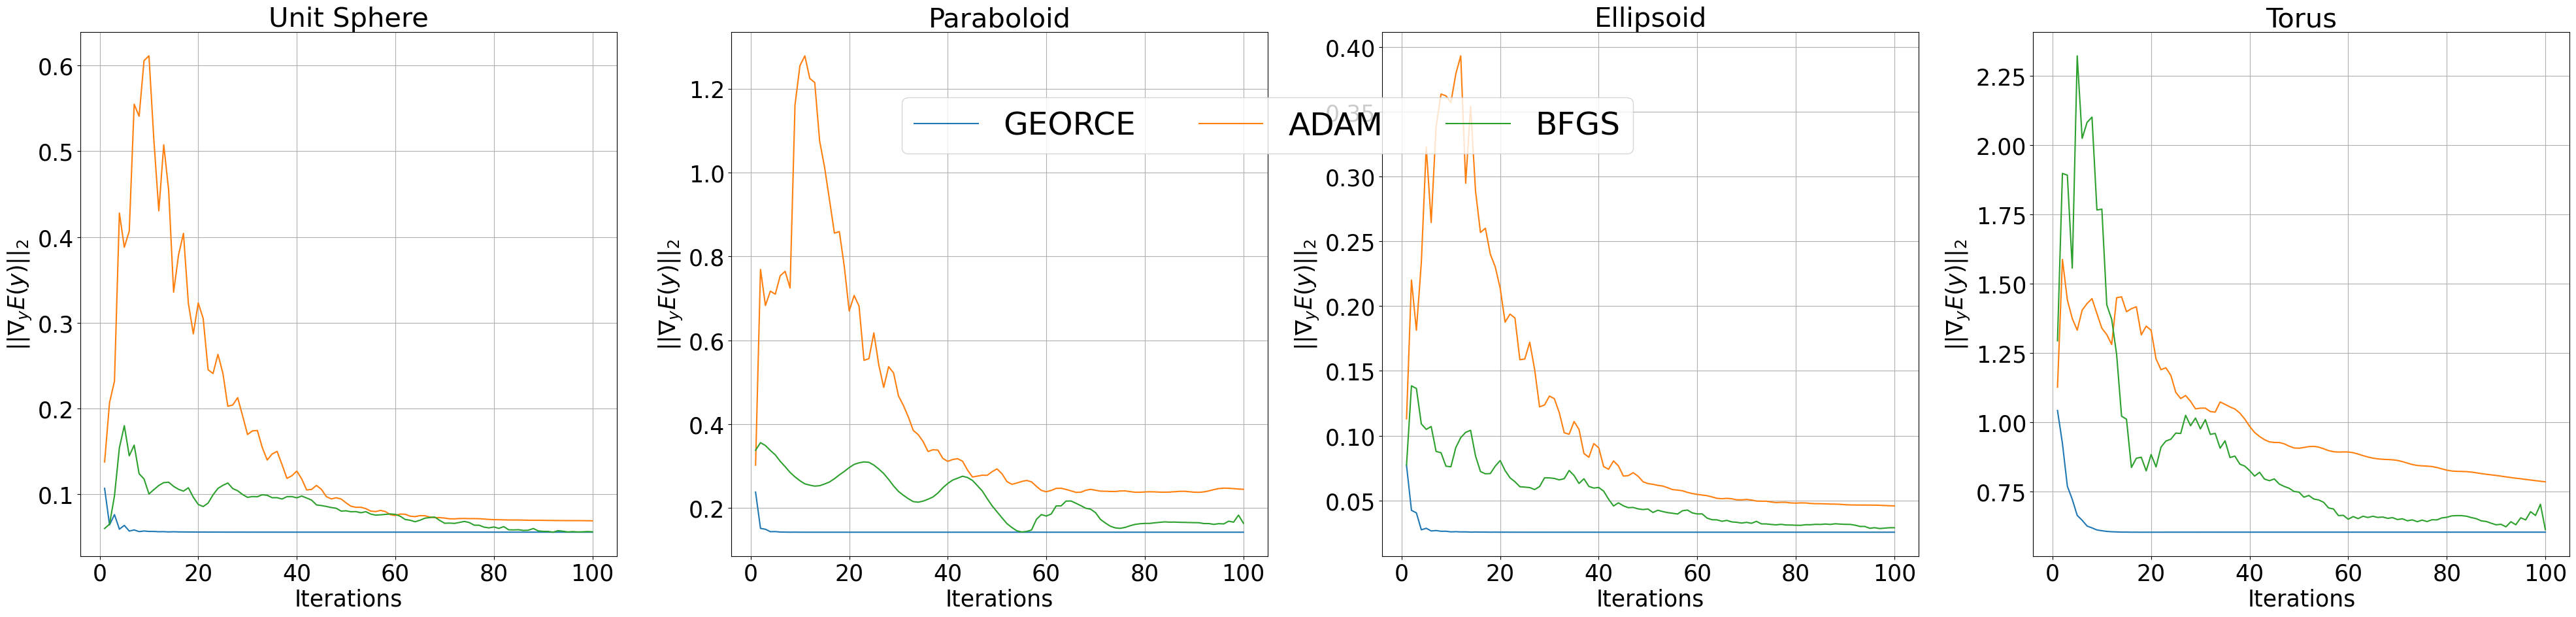

In [64]:
fig = plt.figure(figsize=(40,10))

ax = fig.add_subplot(141)
for key, value in sphere_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0)#, label=f"{key}")
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel(r'$||\nabla_{y}E(y)||_{2}$')
ax.set_title("Unit Sphere")

ax = fig.add_subplot(142)
for key, value in paraboloid_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0)#, label=f"{key}")
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel(r'$||\nabla_{y}E(y)||_{2}$')
ax.set_title("Paraboloid")

ax = fig.add_subplot(143)
for key, value in ellipsoid_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0)#, label=f"{key}")
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel(r'$||\nabla_{y}E(y)||_{2}$')
ax.set_title("Ellipsoid")

ax = fig.add_subplot(144)
for key, value in torus_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.set_xlabel('Iterations')
ax.set_ylabel(r'$||\nabla_{y}E(y)||_{2}$')
ax.set_title("Torus")

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.75), ncol=5, prop={'size': 35})

fig.tight_layout()

save_path = f'{figure_path}synthetic_riemannian_gradients.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()



## Non-Uniqueness Experiments 

### Cut Loci on the Paraboloid and Egg-landshape

#### Egg Landshape

In [17]:
def f_fun(z):
    
    x, y = z[0], z[1]
    
    return jnp.array([x,y,2.0*jnp.cos(x)*jnp.cos(y)])
    

In [18]:
M = RiemannianManifold(f=f_fun)
z0 = 5*jnp.array([-1.,-1.])
zT = 5*jnp.array([1.0,1.])

egg_x0 = M.f(z0)
egg_xT = M.f(zT)

egg_methods = compute_methods(M, z0, zT, rho=0.5, T=1000, max_iter=1000)

/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


#### Paraboloid

In [19]:
M = nParaboloid(dim=2)
z0 = -1.5*jnp.ones(2)
zT = 1.5*jnp.ones(2)

p2_x0 = M.f(z0)
p2_xT = M.f(zT)

cut_loci_paraboloid_methods = compute_methods(M, z0, zT, rho=0.5, T=100, max_iter=1000)

/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


### Plotting 

In [20]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-3.0, 3.0, n_points)
        x2 = jnp.linspace(-3.0,3.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

In [21]:
class EggPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-10.0, 10.0, n_points)
        x2 = jnp.linspace(-10.0,10.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, 2.0*jnp.cos(X1)*jnp.cos(X2)

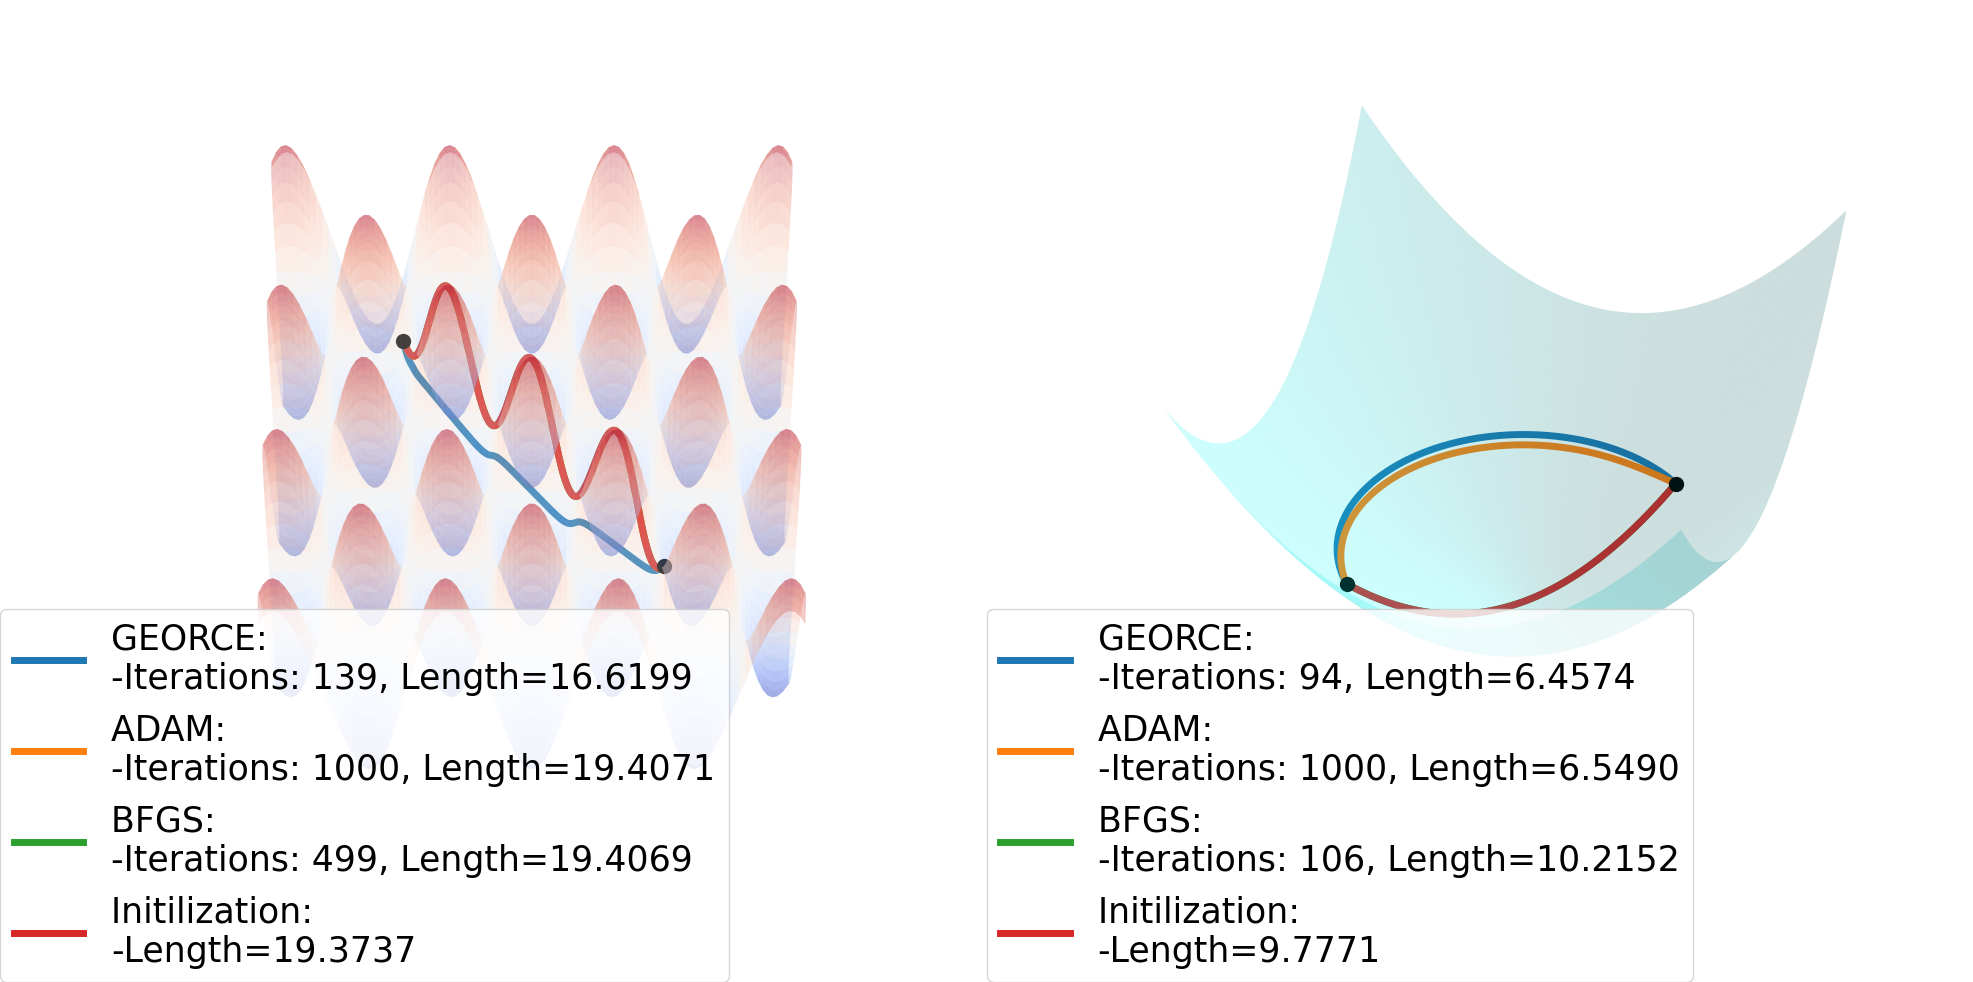

In [22]:
fig = plt.figure(figsize=(20, 10))

#plotting sphere
plot_sphere = EggPlot()
x1,x2,x3 = EggPlot.grid(100)
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, alpha=0.3, cmap=cm.coolwarm)
for key, value in egg_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)
ax.set_axis_off()
ax.view_init(elev=60., azim=0.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0, 0.0), ncol=1)

ax.scatter(egg_x0[0], egg_x0[1], egg_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(egg_xT[0], egg_xT[1], egg_xT[2], color='black', alpha=1.0, s=100)

#plotting paraboloid
plot_sphere = ParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in cut_loci_paraboloid_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)
            
ax.scatter(p2_x0[0], p2_x0[1], p2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(p2_xT[0], p2_xT[1], p2_xT[2], color='black', alpha=1.0, s=100)

#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.5,0.0), ncol=1)

fig.tight_layout()

save_path = f'{figure_path}non_unique_riemannian_geodesics.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()




## Information Geometry with Fisher-Rao metric

### Gaussian Distribution

In [65]:
M = FisherRaoGeometry(distribution='Gaussian')
z0 = jnp.array([-1.0, 0.5])
zT = jnp.array([1.0, 1.0])

gaussian_methods = compute_methods(M, z0, zT, rho=0.5)

/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


In [66]:
mu_geodesic = gaussian_methods['GEORCE']['zt'][:,0]
sigma_geodesic = gaussian_methods['GEORCE']['zt'][:,1]
gaussian_pdf = vmap(lambda mu,sigma: vmap(lambda x: \
                                          M.pdf_gaussian(x,
                                                         jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                                               mu+3*sigma,
                                                                                               100)))(mu_geodesic,
                                                                                                      sigma_geodesic)
gaussian_grid = vmap(lambda mu, sigma: jnp.linspace(mu-3*sigma,
                                                    mu+3*sigma,
                                                    100))(mu_geodesic,
                                                          sigma_geodesic)

### Frechet Distribution

In [67]:
M = FisherRaoGeometry(distribution='Frechet')
z0 = jnp.array([0.5, 0.5])
zT = jnp.array([1.0, 1.0])

frechet_methods = compute_methods(M, z0, zT, rho=0.5)

In [68]:
beta_geodesic = frechet_methods['GEORCE']['zt'][:,0]
lam_geodesic = frechet_methods['GEORCE']['zt'][:,1]
frechet_pdf = vmap(lambda beta,lam: vmap(lambda x: \
                                 M.pdf_frechet(x,jnp.hstack((beta,lam))))(jnp.linspace(0.01,
                                                                                    3.0,
                                                                                        100)))(beta_geodesic,
                                                                                               lam_geodesic)
frechet_grid = vmap(lambda beta, lam: jnp.linspace(0.01,
                                             3.0,
                                             100))(beta_geodesic,
                                                   lam_geodesic)

### Cauchy Distribution

In [69]:
M = FisherRaoGeometry(distribution='Cauchy')
z0 = jnp.array([-1.0, 0.5])
zT = jnp.array([1.0, 1.0])

cauchy_methods = compute_methods(M, z0, zT, rho=0.5)

In [70]:
mu_geodesic = cauchy_methods['GEORCE']['zt'][:,0]
sigma_geodesic = cauchy_methods['GEORCE']['zt'][:,1]
cauchy_pdf = vmap(lambda mu,sigma: vmap(lambda x: \
                                          M.pdf_cauchy(x,
                                                       jnp.hstack((mu,sigma))))(jnp.linspace(mu-3*sigma,
                                                                                             mu+3*sigma,
                                                                                             100)))(mu_geodesic,
                                                                                                    sigma_geodesic)
cauchy_grid = vmap(lambda mu, sigma: jnp.linspace(mu-3*sigma,
                                                  mu+3*sigma,
                                                  100))(mu_geodesic,
                                                        sigma_geodesic)

### Pareto Distribution

In [71]:
M = FisherRaoGeometry(distribution='Pareto')
z0 = jnp.array([0.5, 0.5])
zT = jnp.array([1.0, 1.0])

pareto_methods = compute_methods(M, z0, zT, rho=0.5)

In [72]:
theta_geodesic = frechet_methods['GEORCE']['zt'][:,0]
alpha_geodesic = frechet_methods['GEORCE']['zt'][:,1]
pareto_pdf = vmap(lambda theta,alpha: vmap(lambda x: \
                                 M.pdf_pareto(x,jnp.hstack((theta,alpha))))(jnp.linspace(0.5,
                                                                                        2.0,
                                                                                        100)))(theta_geodesic,
                                                                                               alpha_geodesic)
pareto_grid = vmap(lambda theta, alpha: jnp.linspace(0.5,
                                             2.0,
                                             100))(theta_geodesic,
                                                   alpha_geodesic)

### Plotting

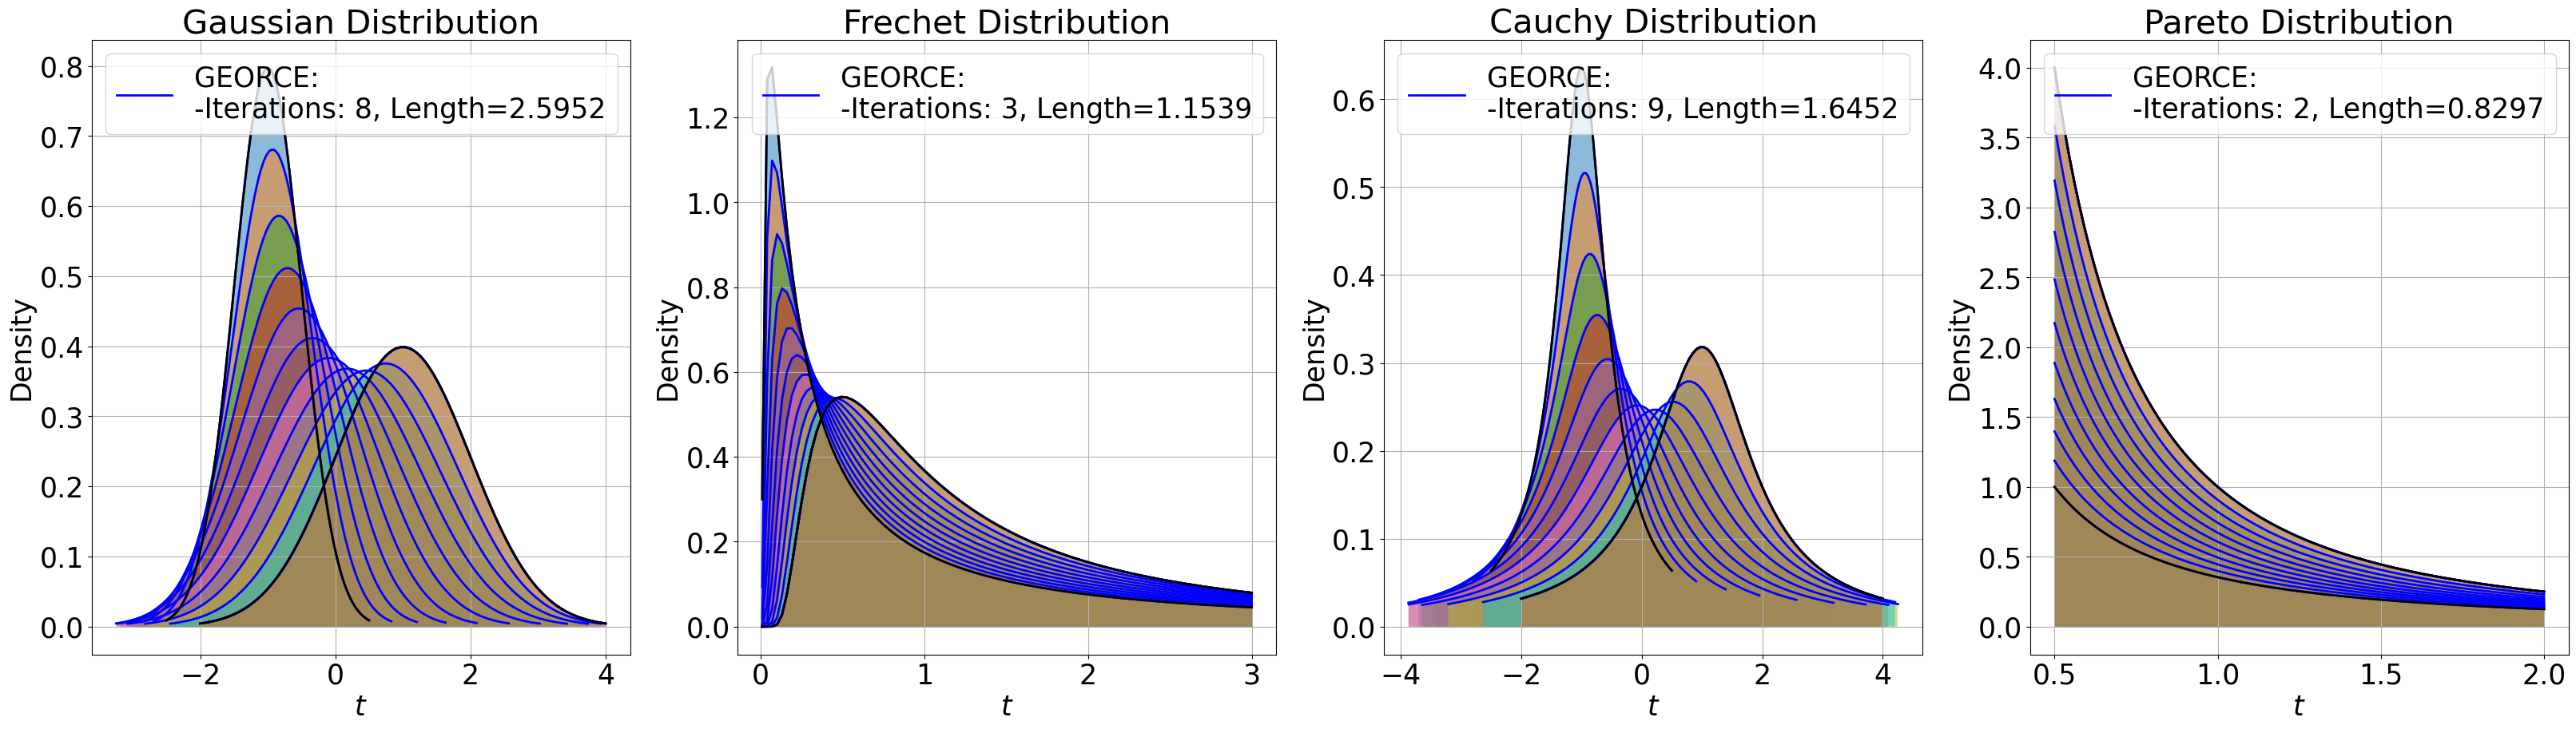

In [76]:
fig = plt.figure(figsize=(40,10))

#Gaussian
ax = fig.add_subplot(141)
for i in range(0, len(gaussian_grid)+10, 10):
    ax.plot(gaussian_grid[i], gaussian_pdf[i], color='blue', linewidth=2.0)
    ax.fill_between(gaussian_grid[i], 
                    gaussian_pdf[i],
                    alpha=0.5,
                    )
ax.plot(gaussian_grid[0], gaussian_pdf[0], color='black', linewidth=2.0)
ax.plot(gaussian_grid[-1], gaussian_pdf[-1], color='blue', 
        alpha=1.0, 
        label=f"GEORCE: \n-Iterations: {gaussian_methods['GEORCE']['idx']}, Length={gaussian_methods['GEORCE']['length']:.4f}", 
        linewidth=2.0
       )
ax.plot(gaussian_grid[-1], gaussian_pdf[-1], color='black', linewidth=2.0)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 25})
ax.set_title(f'Gaussian Distribution')
ax.grid(True)

#Frechet
ax = fig.add_subplot(142)
for i in range(0, len(frechet_grid)+10, 10):
    ax.plot(frechet_grid[i], frechet_pdf[i], color='blue', linewidth=2.0)
    ax.fill_between(frechet_grid[i], 
                    frechet_pdf[i],
                    alpha=0.5,
                    )
ax.plot(frechet_grid[0], frechet_pdf[0], color='black', linewidth=2.0)
ax.plot(frechet_grid[-1], frechet_pdf[-1], color='blue', 
        alpha=1.0, 
        label=f"GEORCE: \n-Iterations: {frechet_methods['GEORCE']['idx']}, Length={frechet_methods['GEORCE']['length']:.4f}", 
        linewidth=2.0
       )
ax.plot(frechet_grid[-1], frechet_pdf[-1], color='black', linewidth=2.0)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 25})
ax.set_title(f'Frechet Distribution')
ax.grid(True)

#Cauchy
ax = fig.add_subplot(143)
for i in range(0, len(cauchy_grid)+10, 10):
    ax.plot(cauchy_grid[i], cauchy_pdf[i], color='blue', linewidth=2.0)
    ax.fill_between(cauchy_grid[i], 
                    cauchy_pdf[i],
                    alpha=0.5,
                    )
ax.plot(cauchy_grid[0], cauchy_pdf[0], color='black', linewidth=2.0)
ax.plot(cauchy_grid[-1], cauchy_pdf[-1], color='blue', 
        alpha=1.0, 
        label=f"GEORCE: \n-Iterations: {cauchy_methods['GEORCE']['idx']}, Length={cauchy_methods['GEORCE']['length']:.4f}", 
        linewidth=2.0
       )
ax.plot(cauchy_grid[-1], cauchy_pdf[-1], color='black', linewidth=2.0)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 25})
ax.set_title(f'Cauchy Distribution')
ax.grid(True)

#Pareto
ax = fig.add_subplot(144)
for i in range(0, len(pareto_grid)+10, 10):
    ax.plot(pareto_grid[i], pareto_pdf[i], color='blue', linewidth=2.0)
    ax.fill_between(pareto_grid[i], 
                    pareto_pdf[i],
                    alpha=0.5,
                    )
ax.plot(pareto_grid[0], pareto_pdf[0], color='black', linewidth=2.0)
ax.plot(pareto_grid[-1], pareto_pdf[-1], color='blue', 
        alpha=1.0, 
        label=f"GEORCE: \n-Iterations: {pareto_methods['GEORCE']['idx']}, Length={pareto_methods['GEORCE']['length']:.4f}", 
        linewidth=2.0
       )
ax.plot(pareto_grid[-1], pareto_pdf[-1], color='black', linewidth=2.0)
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'Density')
ax.legend(loc=2, prop={'size': 25})
ax.set_title(f'Pareto Distribution')
ax.grid(True)

save_path = f'{figure_path}information_geometry_geodesics.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

In [74]:
print("Gaussian")
for key, value in gaussian_methods.items():
    if gaussian_methods[key]['length'] is not None:
        print(f"Method: {key} \t Length={gaussian_methods[key]['length']:.4f} \t Iterations={gaussian_methods[key]['idx']}")
        
print("\nFrechet")
for key, value in frechet_methods.items():
    if frechet_methods[key]['length'] is not None:
        print(f"Method: {key} \t Length={frechet_methods[key]['length']:.4f} \t Iterations={frechet_methods[key]['idx']}")
        
print("\nCauchy")
for key, value in cauchy_methods.items():
    if cauchy_methods[key]['length'] is not None:
        print(f"Method: {key} \t Length={cauchy_methods[key]['length']:.4f} \t Iterations={cauchy_methods[key]['idx']}")
        
print("\nPareto")
for key, value in pareto_methods.items():
    if pareto_methods[key]['length'] is not None:
        print(f"Method: {key} \t Length={pareto_methods[key]['length']:.4f} \t Iterations={pareto_methods[key]['idx']}")

Gaussian
Method: GEORCE 	 Length=2.5952 	 Iterations=8
Method: ADAM 	 Length=2.6519 	 Iterations=100
Method: BFGS 	 Length=2.5994 	 Iterations=100
Method: Initilization 	 Length=2.8559 	 Iterations=None

Frechet
Method: GEORCE 	 Length=1.1539 	 Iterations=3
Method: ADAM 	 Length=1.1589 	 Iterations=100
Method: BFGS 	 Length=1.1546 	 Iterations=100
Method: Initilization 	 Length=1.1587 	 Iterations=None

Cauchy
Method: GEORCE 	 Length=1.6452 	 Iterations=9
Method: ADAM 	 Length=1.6930 	 Iterations=100
Method: BFGS 	 Length=1.6466 	 Iterations=100
Method: Initilization 	 Length=1.9626 	 Iterations=None

Pareto
Method: GEORCE 	 Length=0.8297 	 Iterations=2
Method: ADAM 	 Length=0.8302 	 Iterations=100
Method: BFGS 	 Length=0.8295 	 Iterations=100
Method: Initilization 	 Length=0.8331 	 Iterations=None


## Plotting Log Map

In [8]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

In [264]:
class TorusPlot(ABC):
    def __init__(self, R:float=3.0, r:float=1.0):
        
        self.R = R
        self.r = r
        
    def grid(self, n_points:int=100):
        
        U = jnp.linspace(0, 2*jnp.pi, n_points)
        V = jnp.linspace(0, 2*jnp.pi, n_points)
        U, V = jnp.meshgrid(U, V)
        
        return U, V, None

In [269]:
class TorusPlot(ABC):
    def __init__(self, R:float=3.0, r:float=1.0):
        
        self.R = R
        self.r = r
        
    def grid(self, n_points:int=100):
        
        U = jnp.linspace(0, 2*jnp.pi, n_points)
        V = jnp.linspace(0, 2*jnp.pi, n_points)
        U, V = jnp.meshgrid(U, V)
        X = (self.R+self.r*jnp.cos(V))*jnp.cos(U)
        Y = (self.R+self.r*jnp.cos(V))*jnp.sin(U)
        Z = self.r*jnp.sin(V)
        
        return X, Y, Z

In [10]:
M = nParaboloid(dim=2)
z0_para = jnp.ones(2, dtype=jnp.float32)

In [259]:
plot_paraboloid = ParaboloidPlot()
x1_para,x2_para,x3_para = plot_paraboloid.grid(100)

In [243]:
Geodesic = jit(GEORCE(M=M,
                      init_fun=None,
                      T=100,
                      line_search_method="soft",
                      max_iter=100,
                      line_search_params={'rho': 0.5},
                     ))

In [244]:
from jax import lax
def get_cut_loci(z0, zT, eps, M):

    def compute_dist(e):
        

        Geodesic = jit(GEORCE(M=M,
                              init_fun=lambda x,y,T: e*(zT-z0)+z0,
                              T=100,
                              line_search_method="soft",
                              max_iter=1000,
                              line_search_params={'rho': 0.5},
                             ))
    
        zt = Geodesic(z0,zT)[0]
    
        return zt, jit(M.length)(zt)

    zt, dist = vmap(jit(compute_dist))(eps)
    min_dist = jnp.argmin(dist)
    zt_geodesic = zt[min_dist]

    error = jnp.mean(jnp.linalg.norm(zt-zt_geodesic, axis=0))

    return lax.cond(error < 1e-1, lambda *_: jnp.min(dist), lambda *_: -1.)


In [245]:
import jax.random as jrandom
key = jrandom.key(2712)
key, subkey = jrandom.split(key)
eps = jrandom.normal(subkey, shape=(10,100-1,2))

In [246]:
jit_fun = jit(get_cut_loci, static_argnums=3)
cut_loci_para = vmap(vmap(lambda u,v: jit_fun(z0_para,jnp.stack((u,v)),eps,M)))(x1_para,x2_para)

In [247]:
from jax import lax
def get_cut_loci_torus(z0, zT, M):

    def compute_dist(zT):
    
        zt = Geodesic(z0,zT)[0]
    
        return zt, dist_fun(zt)

    Geodesic = jit(GEORCE(M=M,
                          init_fun=None,
                          T=100,
                          line_search_method="soft",
                          max_iter=1000,
                          line_search_params={'rho': 0.5},
                          ))
    dist_fun = jit(M.length)
    zT = jnp.vstack((zT,
                     jnp.array([zT[0]-2.*jnp.pi, zT[1]]),
                     jnp.array([zT[0], zT[1]-2.*jnp.pi]),
                     zT-2.*jnp.pi,
                    ))

    zt, dist = vmap(jit(compute_dist))(zT)
    dist_array = jnp.abs(dist-jnp.min(dist))

    return lax.cond(jnp.sum(dist_array < 1e-1) < 2, lambda *_: jnp.min(dist), lambda *_: -1.)


In [254]:
import pickle
data = 'cut_locus/Paraboloid.pkl'

In [255]:
with open(data, 'rb') as f:
    values = pickle.load(f)

In [257]:
cut_loci_para = values['cl']

In [267]:
import pickle
data = 'cut_locus/T2.pkl'

with open(data, 'rb') as f:
    values = pickle.load(f)

cut_loci_torus = values['cl']

In [248]:
M = T2(R=3.0, r=1.0)
z0_t2 = 0.0*jnp.array([jnp.pi, jnp.pi])

In [249]:
z0_t2

KeyboardInterrupt: 

In [265]:
plot_torus = TorusPlot()
x1_t2,x2_t2,x3_t2 = plot_torus.grid(100)

In [237]:
jit_fun = jit(get_cut_loci_torus, static_argnums=2)
cut_loci_torus = vmap(vmap(lambda u,v: jit_fun(z0_t2,jnp.stack((u,v)),M)))(x1_t2,x2_t2)

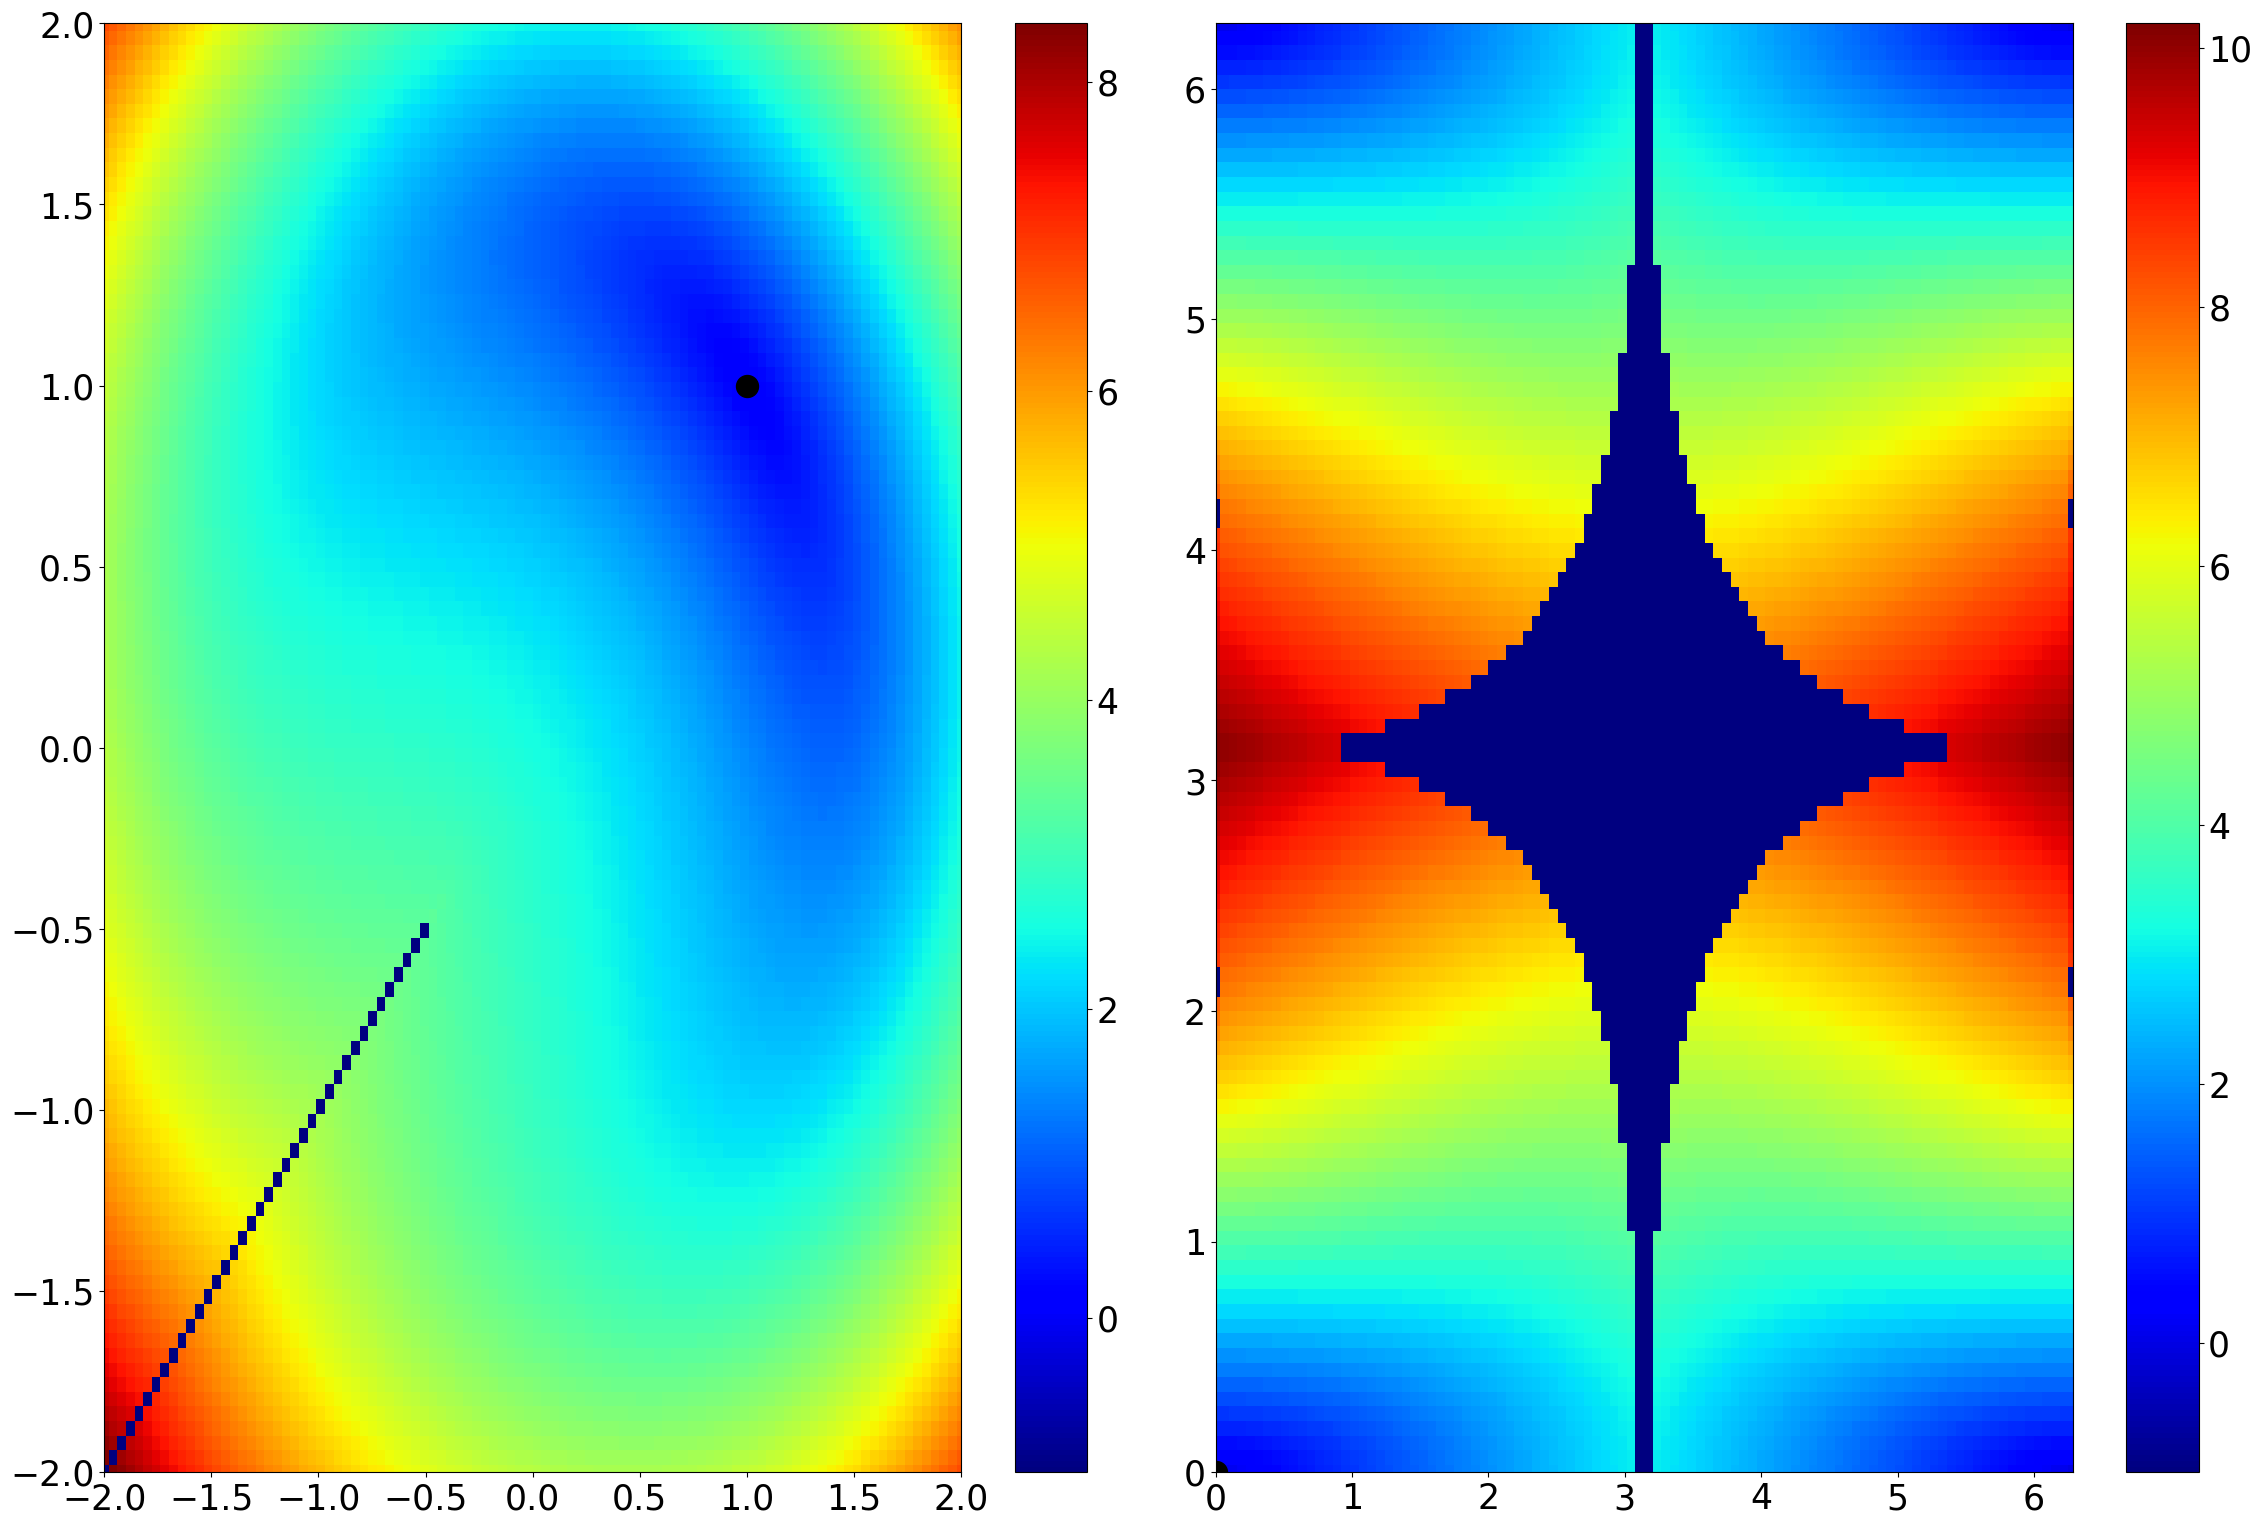

In [270]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
c = ax.pcolormesh(x1_para, x2_para, cut_loci_para, cmap=cm.jet, vmin=jnp.min(cut_loci_para), vmax=jnp.max(cut_loci_para))
ax.scatter(z0_para[0], z0_para[1], color='black', s=250)
ax.axis([x1_para.min(), x1_para.max(), x2_para.min(), x2_para.max()])
fig.colorbar(c, ax=ax)

ax = fig.add_subplot(122)
c = ax.pcolormesh(x1_t2, x2_t2, cut_loci_torus, cmap=cm.jet, vmin=jnp.min(cut_loci_torus), vmax=jnp.max(cut_loci_torus))
ax.scatter(z0_t2[0], z0_t2[1], color='black', s=250)
ax.axis([x1_t2.min(), x1_t2.max(), x2_t2.min(), x2_t2.max()])
fig.colorbar(c, ax=ax)

save_path = f'{figure_path}cut_locus_2d.pdf'
fig.tight_layout()
fig.subplots_adjust(left=-0.11, bottom=-0.5) 

fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

In [276]:
cut_loci_para = cut_loci_para.at[cut_loci_para > -0.5].set(0.0)
cut_loci_torus = cut_loci_torus.at[cut_loci_torus > -0.5].set(0.0)

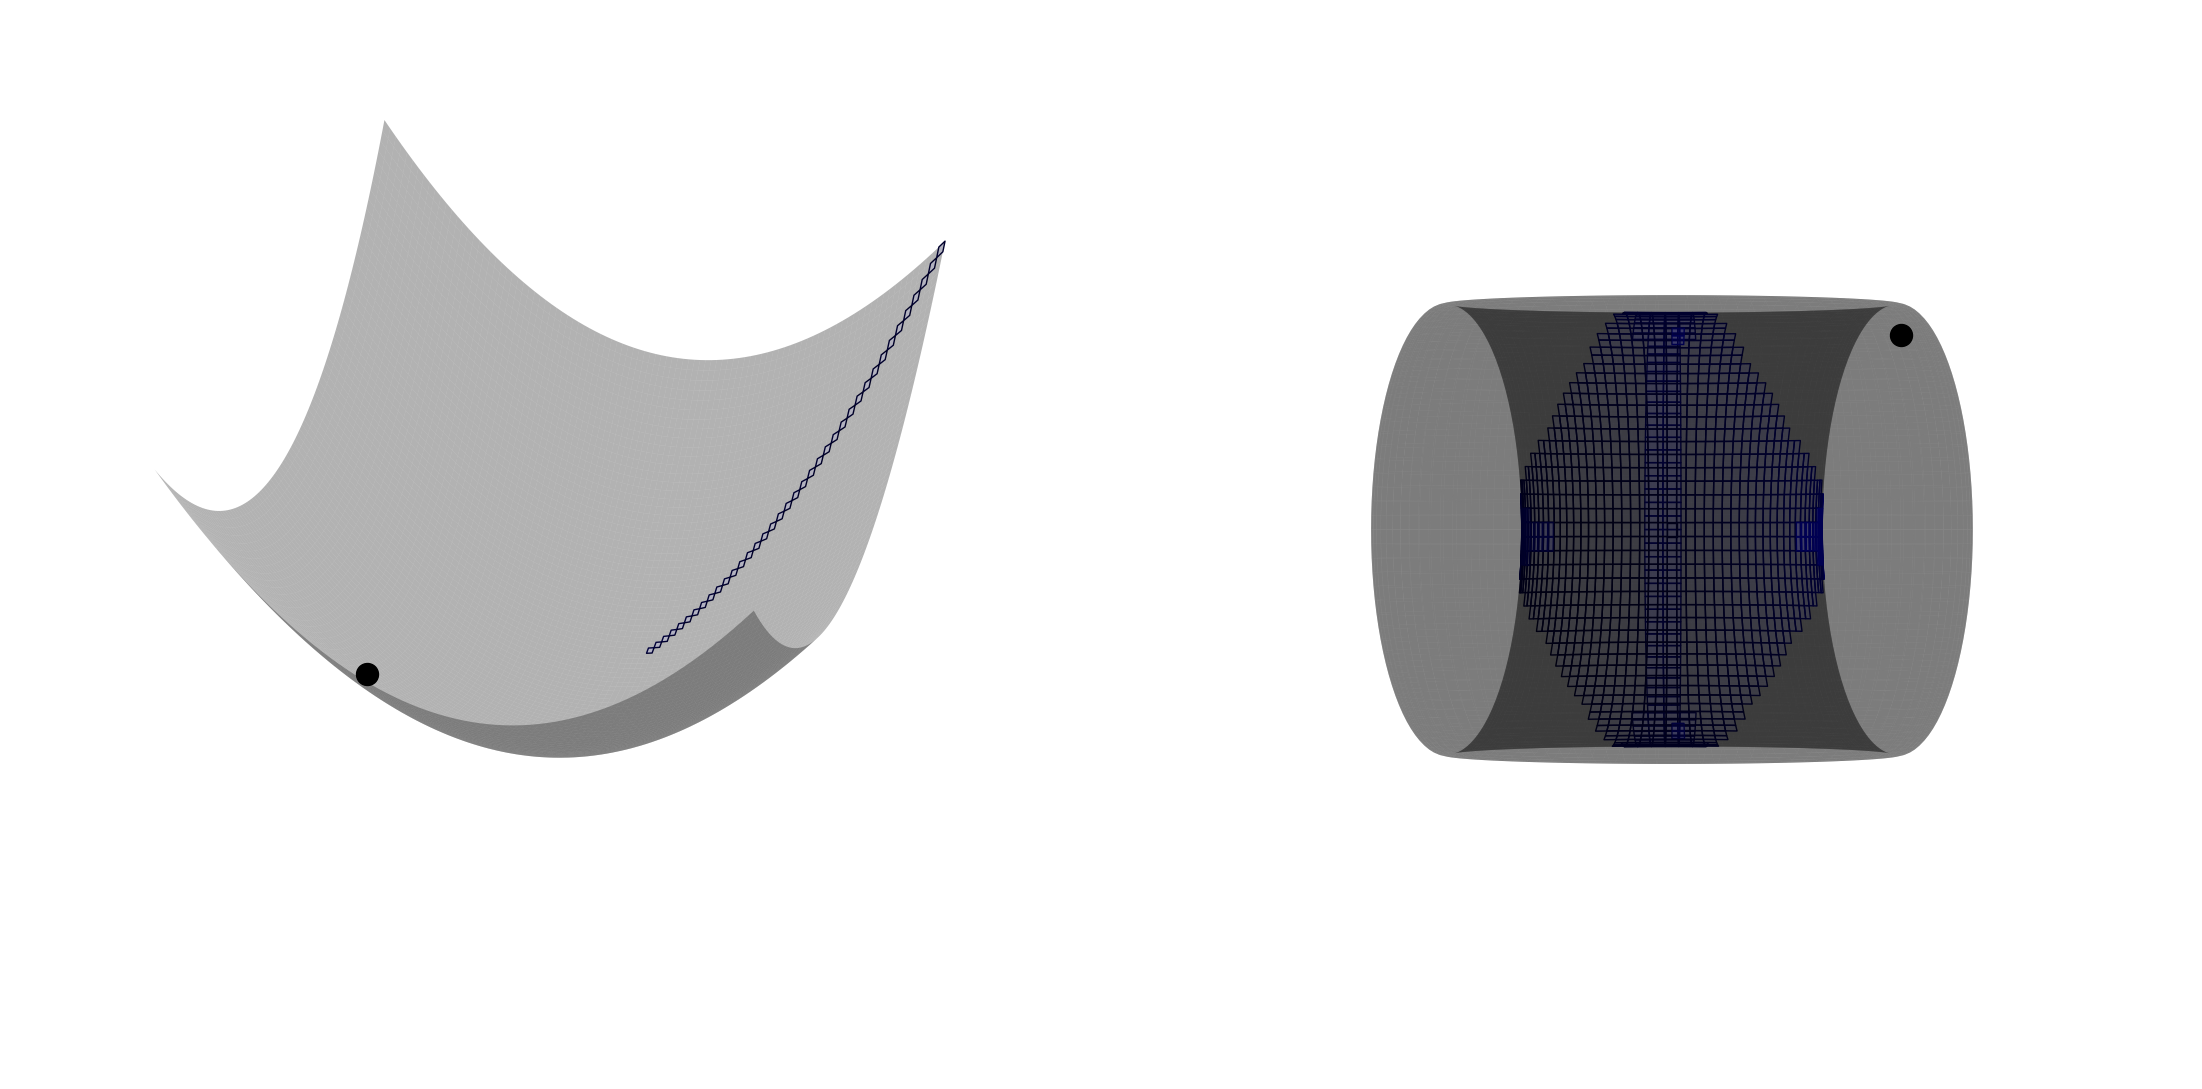

In [277]:
fig = plt.figure(figsize=(20,10))

#plotting paraboloid
ax = fig.add_subplot(121, projection='3d')
M = nParaboloid(dim=2)
plot_paraboloid = ParaboloidPlot()
x1_para,x2_para,x3_para = plot_paraboloid.grid(100)

ax.scatter(M.f(z0_para)[0], M.f(z0_para)[1], M.f(z0_para)[2], s=250, color='black')
ax.plot_surface(x1_para, x2_para, x3_para, rstride=1, cstride=1, alpha=0.3, 
                facecolors=plt.cm.jet(cut_loci_para/jnp.max(cut_loci_para)))
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)

ax = fig.add_subplot(122, projection='3d')
M = T2(R=3.0, r=1.0)
plot_paraboloid = TorusPlot()
x1_t2_plot,x2_t2_plot,x3_t2_plot = plot_paraboloid.grid(100)

ax.scatter(M.f(z0_para)[0], M.f(z0_para)[1], M.f(z0_para)[2], s=250, color='black')
ax.plot_surface(x1_t2_plot, x2_t2_plot, x3_t2_plot, rstride=1, cstride=1, alpha=0.3, 
                facecolors=plt.cm.jet(cut_loci_torus/jnp.max(cut_loci_torus)))
ax.set_axis_off()
ax.view_init(elev=180., azim=0.)

save_path = f'{figure_path}cut_locus_3d.pdf'
fig.tight_layout()
fig.subplots_adjust(left=-0.11, bottom=-0.5) 

fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()


In [ ]:
log_map_length = jnp.linalg.norm(log_map, axis=-1)

In [ ]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
ax.scatter(z0[0], z0[1], color='black', s=100)
ax.quiver(x1, x2, log_map[:,:,0], log_map[:,:,1], color='r')
ax.set_title('Log Map Modulo Scaling')
ax.set_xlabel(r'$u_{0}^{1}$')
ax.set_ylabel(r'$u_{0}^{2}$')
ax.grid(True)

#plotting paraboloid
ax = fig.add_subplot(122, projection='3d')
ax.scatter(M.f(z0)[0], M.f(z0)[1], M.f(z0)[2], s=250, color='black')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, alpha=0.3, 
                facecolors=plt.cm.jet(log_map_length/jnp.max(log_map_length)))
ax.set_axis_off()

save_path = f'{figure_path}log_map.pdf'
fig.tight_layout()
fig.subplots_adjust(left=-0.11, bottom=-0.5) 

fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()


## Estimating the Cut Locus

In [33]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-3.0, 3.0, n_points)
        x2 = jnp.linspace(-3.0,3.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

In [34]:
def f_fun(z):
    
    x, y = z[0], z[1]
    
    return jnp.array([x,y,2.0*jnp.cos(x)*jnp.cos(y)])
    

In [35]:
M = RiemannianManifold(f=f_fun)

In [36]:
z0 = 5*jnp.array([-1.,-1.])

In [9]:
M = nParaboloid(dim=2)
z0 = jnp.ones(2, dtype=jnp.float32)*1.5

In [37]:
plot_paraboloid = ParaboloidPlot()
x1,x2,x3 = plot_paraboloid.grid(100)

In [38]:
x1 += z0[0]
x2 += z0[1]

In [45]:
Geodesic = jit(GEORCE(M=M,
                      init_fun=None,
                      T=1000,
                      line_search_method="soft",
                      max_iter=100,
                      line_search_params={'rho': 0.5},
                     ))

In [46]:
def get_log_map(z0, zT):

    zt = Geodesic(z0,zT)[0]

    return zt[1]-zt[0]
    

In [47]:
log_map = vmap(vmap(lambda u,v: get_log_map(z0,jnp.stack((u,v)))))(x1,x2)

In [48]:
log_map_length = jnp.linalg.norm(log_map, axis=-1)

In [49]:
x1.shape

(100, 100)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(z0[0], z0[1], color='black', s=100)
ax.quiver(x1, x2, log_map[:,:,0], log_map[:,:,1], color='r')
ax.set_title('Log Map Modulo Scaling')
ax.set_xlabel(r'$u_{0}^{1}$')
ax.set_xlabel(r'$u_{0]^{2}$')
ax.set_grid(True)

## Bregman Geometry

In [78]:
def potential_function(x):

    return (x[0]**2)/(2*x[1])+0.5*jnp.log(2*jnp.pi/x[1])

In [79]:
M = RiemannianManifold(G=hessian(potential_function))

In [80]:
z0 = jnp.array([-1.0, 0.5])
zT = jnp.array([1.0, 1.0])

In [81]:
Geodesic = jit(GEORCE(M=M,
                      init_fun=None,
                      T=100,
                      line_search_method="soft",
                      max_iter=1000,
                      line_search_params={'rho': 0.5},
                     ))

In [82]:
bregman_methods = compute_methods(M, z0, zT, rho=0.5,T=100, max_iter=100)

/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:122: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/riemannian/scipy_optimization.py:137: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


In [83]:
x1 = jnp.linspace(-1.1,1.1,100)
x2 = jnp.linspace(0.1,2.1,100)
X1, X2 = jnp.meshgrid(x1,x2)

In [84]:
heat_map = vmap(vmap(lambda u,v: potential_function(jnp.stack((u,v)))))(X1,X2)

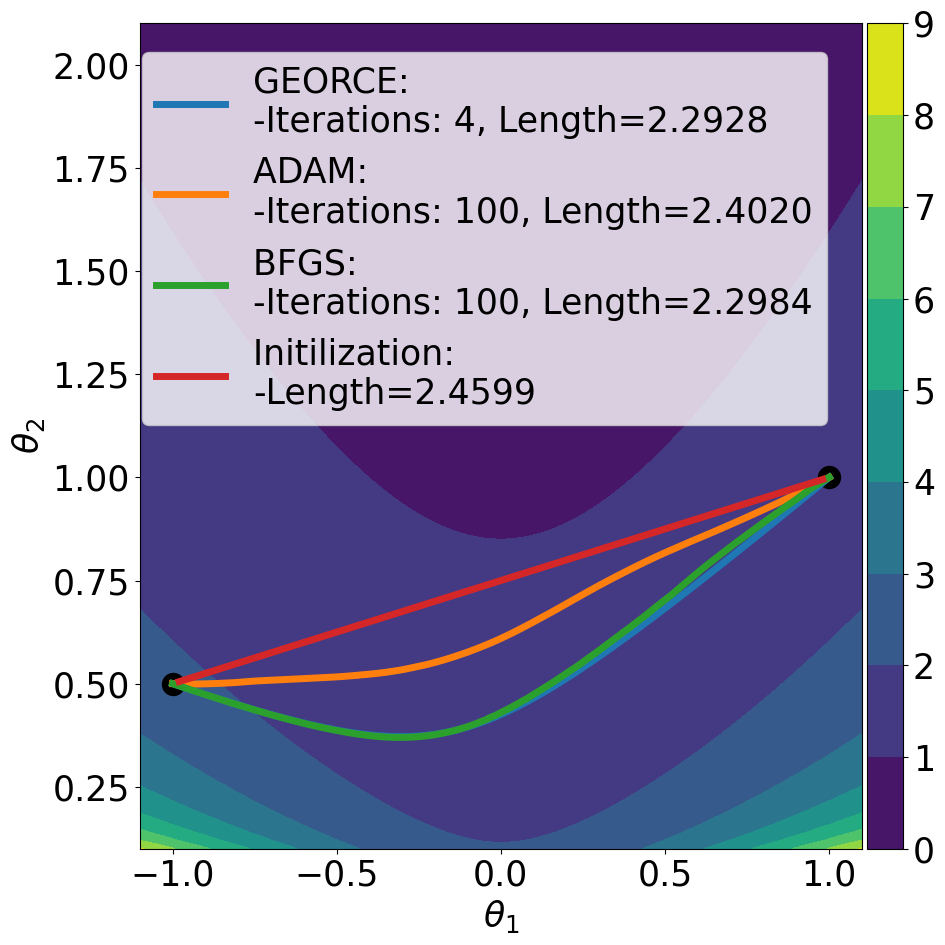

In [88]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#plotting paraboloid
contourf_ = ax.contourf(X1,X2,heat_map)

for key, value in bregman_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['zt'][:,0], value['zt'][:,1], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['zt'][:,0], value['zt'][:,1], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.15, 0.55), ncol=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(contourf_, cax=cax, orientation='vertical')

ax.scatter(z0[0], z0[1], color='black', alpha=1.0, s=250)
ax.scatter(zT[0], zT[1], color='black', alpha=1.0, s=250)

ax.set_xlabel(r'$\theta_{1}$')
ax.set_ylabel(r'$\theta_{2}$')

fig.tight_layout()

save_path = f'{figure_path}bregman_geometry.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()